In [0]:
pip install livelossplot

In [0]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot.tf_keras import PlotLossesCallback
import tensorflow as tf

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import zipfile
with zipfile.ZipFile('/content/drive/My Drive/emotion recognition/test.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/test')

with zipfile.ZipFile('/content/drive/My Drive/emotion recognition/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/train')

In [0]:
path_train = "/content/train/"
path_val = "/content/test/"

### Sample Image

In [0]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def plot_example_images(plt):
    img_size = 48
    plt.figure(0, figsize=(12,20))
    ctr = 0

    for expression in os.listdir(path_train):
        for i in range(1,6):
            ctr += 1
            plt.subplot(7,5,ctr)
            img = load_img(path_train + expression + "/" +os.listdir(path_train + expression)[i], target_size=(img_size, img_size))
            plt.imshow(img, cmap="gray")

    plt.tight_layout()
    return plt

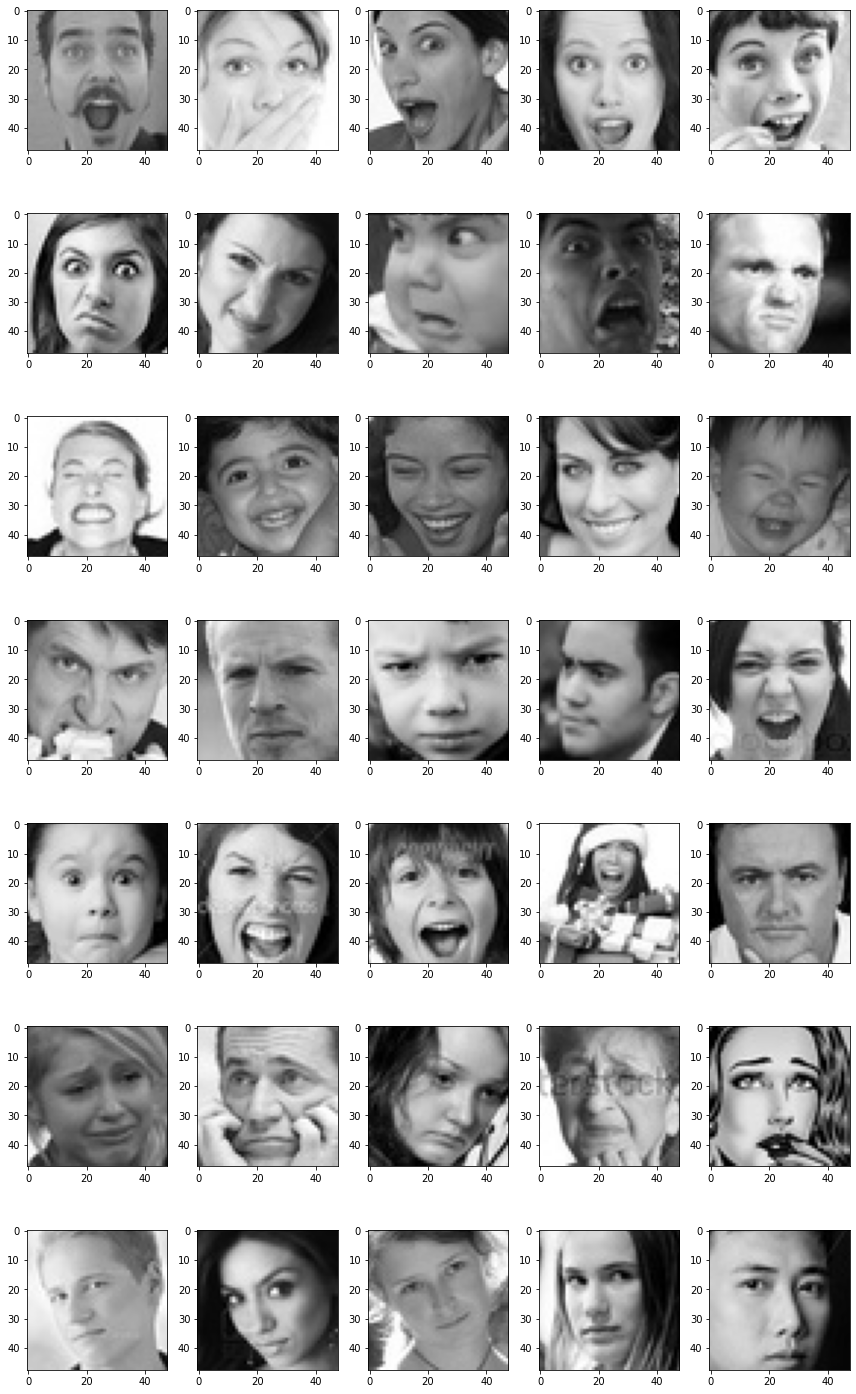

In [0]:
plot_example_images(plt).show()

So, these are the images. The dataset was found on Kaggle and I like it a lot because it's very diverse. Here we have men and women; children, adults, and elders; different skin color; different face orientation; there are even some video game characters. This is extremely useful for that kind of project where you have to read the faces of any person that appears in video. And as a pretty basic rule says, train and test sets should come from the same distribution. So network train on pics of orks from some video game will have some troubles with human faces, even though for us they seem to be quite similar and vice versa.


In [0]:
for expression in os.listdir(path_train):
  print(str(len(os.listdir(path_train + expression)))+ ' ' + expression + ' images')

3171 surprise images
436 disgust images
7215 happy images
3995 angry images
4097 fear images
4830 sad images
4965 neutral images


Around 4 000 for each class, 7200 for happy faces, and only 436 for disgust. This problem should be solved by a little bit of data augmentation later.

Advantages of using ImageDataGenerator

- Easy to write — We just have to call keras.preprocessing.image.ImageDataGenerator() and set values for different parameters like *horizontal_flip, vertical_flip, rescale, brightness_range, zoom_range, rotation_range*, etc
- Less to remember — We need not manually code cv2 image processing techniques for flipping, varying brightness, zoom etc
- Easy to combine — we can easily combine ImageDataGenerator with some custom image generator.
- Fast — If you want to use multiple threads to load training data, Keras ImageDataGenerator.flow() has a workers argument, which can be tuned, thus reducing the training time by orders of magnitude[.](https://medium.com/@arindambaidya168/https-medium-com-arindambaidya168-using-keras-imagedatagenerator-b94a87cdefad)

In [0]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow_from_directory(path_train, target_size = (img_size, img_size),
                                                    color_mode = 'grayscale', batch_size = batch_size,
                                                    class_mode = 'categorical', shuffle = True)
datagen_val = ImageDataGenerator(horizontal_flip=True)
val_generator = datagen_val.flow_from_directory(path_val, target_size = (img_size, img_size),
                                                    color_mode = 'grayscale', batch_size = batch_size,
                                                    class_mode = 'categorical', shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Model

Inspired by Goodfellow, I.J., et.al. (2013). Challenged in representation learning: A report of three machine learning contests. *Neural Networks*, 64, 59-63[.](https://arxiv.org/pdf/1307.0414.pdf)

In [0]:
model = Sequential()

model.add(Conv2D(64, (3,3), padding = 'same', input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr = 0.0005)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 128)       5

### Train and Evaluate

In [0]:
epoch = 50
steps_per_epoch = train_generator.n//train_generator.batch_size
val_steps = val_generator.n//val_generator.batch_size

checkpoint = ModelCheckpoint('model_weights.h5', monitor='val_accuracy',
                             save_weights_only = True, mode = 'max', verbose = 1)
reduce_lr = ReduceLROnPlateau(monito = 'val_loss', factor = 0.1, patience = 2, 
                              min_lr = 0.00001, mode = 'auto')
callbacks = [checkpoint, reduce_lr]

history = model.fit(
    x = train_generator,
    steps_per_epoch = steps_per_epoch, 
    epochs = epoch,
    validation_data = val_generator,
    validation_steps = val_steps,
    callbacks = callbacks
)

In [0]:
print('Train accuracy after 50 epochs {:.5}\nTest accuracy after 50 epochs {:.5}'.format(history.history['accuracy'][-1], history.history['val_accuracy'][-1]))

Train accuracy after 50 epochs 0.66211
Test accuracy after 50 epochs 0.64397


Looks not bad. Obviously it's far from current state-of-art models, but to protect the model Iwant to say that even my opinion sometimes doen't correspond to the class that the image was initially marked as. So I consider using percentage labels more reasonable. For example: this face is 42% happy, 35% suprised etc. 

### Model as JSON

In [0]:
model_json = model.to_json()
with open('model.json', 'w') as json_file:
  json_file.write(model_json)